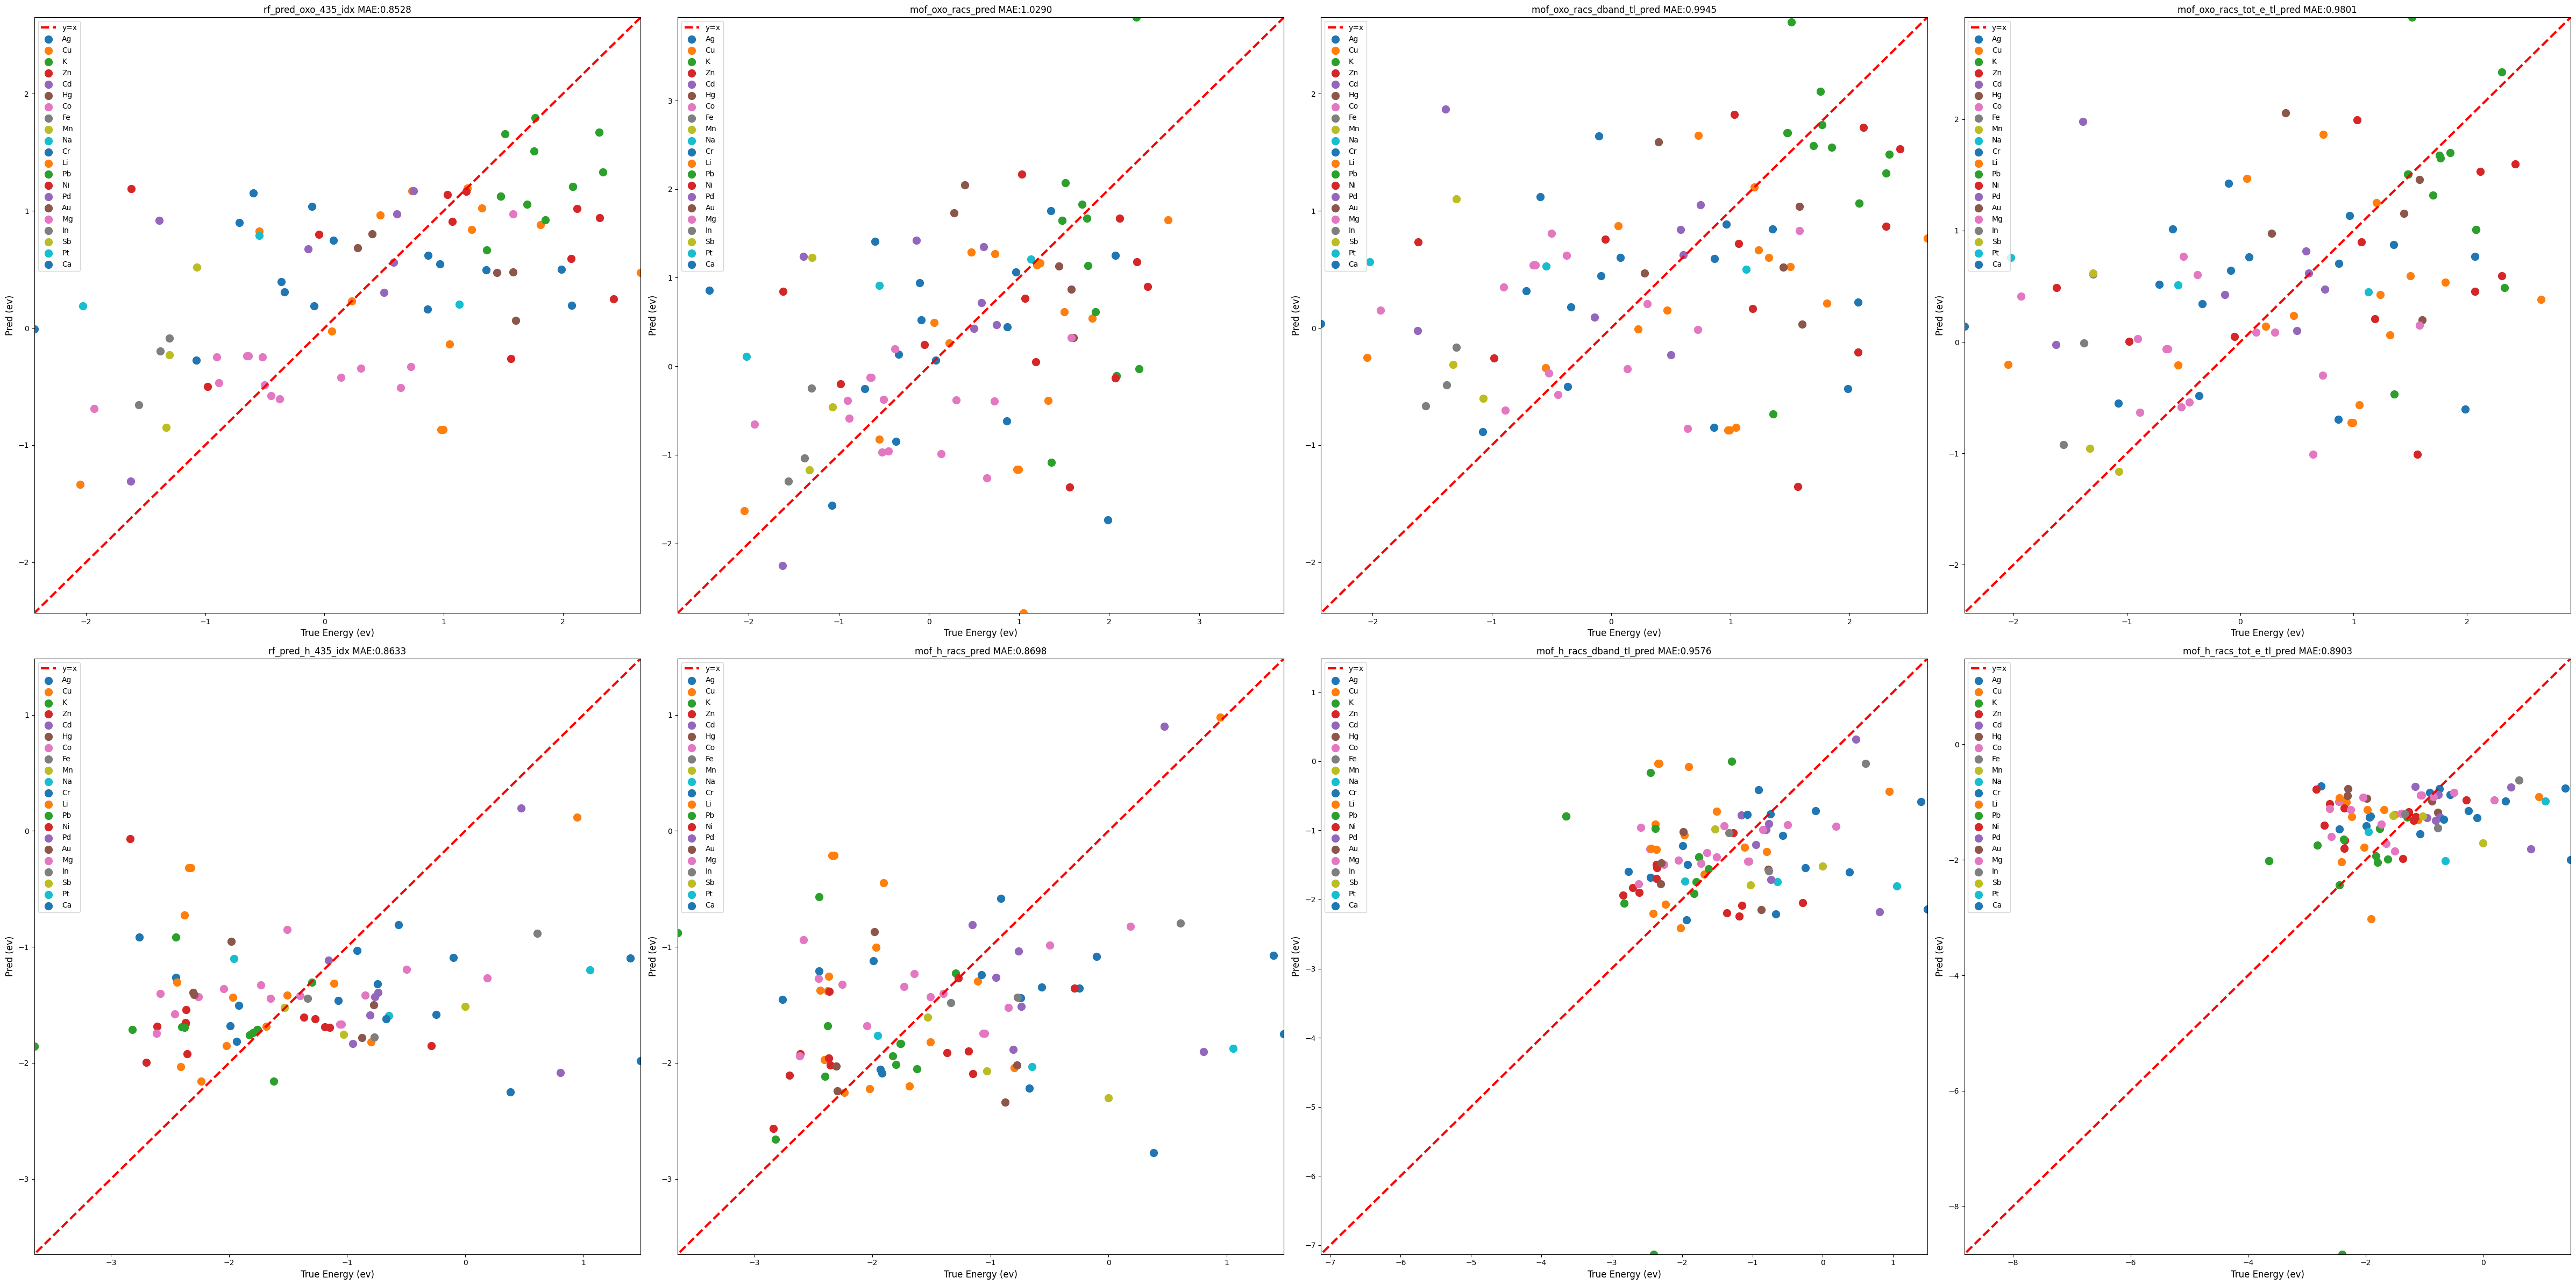

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
import colorlover as cl

# Create a figure with 4x4 subplots
props = ['oxo','h']
# columns = ["rf", "align-raw", "nn", "align-tl"]

n_rows = 1



src_file_path = "./labels/qmofruns_2_suffled.csv"
df_source = pd.read_csv(src_file_path, index_col = 0)
df_source['ids'] = df_source['MOF'] +'.cif_'+ df_source['Site'].astype(str)
df_source = df_source.drop_duplicates(subset = 'ids')

n = 4

# Example data for each subplot
fig, axes = plt.subplots(len(props), n, figsize=(12 * n, 12 * len(props)))
for k, prop in enumerate(props):
    rf_racs = f"./output/rf_pred_{prop}_435_idx.csv"
    nn_racs_only = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_pred.csv"
    nn_racs_dband = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_dband_tl_pred.csv"
    nn_racs_tot_e = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_tot_e_tl_pred.csv"

    file_paths = [rf_racs, nn_racs_only, nn_racs_dband, nn_racs_tot_e]
    for i, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, index_col = 0)

        df = df.merge(df_source, how='inner', left_on='ids_test', right_on = 'ids')

        preds = df["predictions"].values
        preds = np.clip(preds, None, 4)
        df['predictions'] = preds
        labels = df["labels"].values
        mae = np.mean(np.absolute(preds - labels))
        
        axes[k][i].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
        metals = df['Metal'].unique()
        axes[k][i].set_xlim(min(min(labels), min(preds)), max(max(labels), max(preds)))
        axes[k][i].set_ylim(min(min(labels), min(preds)), max(max(labels), max(preds)))
        axes[k][i].set_xlabel('True Energy (ev)', fontsize=12)
        axes[k][i].set_ylabel('Pred (ev)', fontsize=12)
        axes[k][i].set_title(f"{file_path.split('/')[-1].rstrip('.csv')} MAE:{mae:.4f}", fontsize=12)
        colormap = cl.to_numeric(cl.scales['12']['qual']['Set3'])
        # colors = [cl.to_numeric(c) for c in colormap]
        for j, metal in enumerate(metals):
            labels = df[df["Metal"] == metal]['labels'].values
            preds = df[df["Metal"] == metal]['predictions'].values
            axes[k][i].scatter(labels, preds, s=100, marker='o', label = metal)


        axes[k][i].legend()
# for i in range(n_rows):
#     for j in range(n_cols):
#         row = rows[i]
#         col = columns[j]
#         axes[i, j].set_title(f'{row}_{col}')
#         filename = "_".join([col.split("_")[0], row, col.split("_")[1], prop]) + '.csv'
#         df = pd.read_csv(os.path.join("pred", filename))
#         preds = df["predictions"].values
#         labels = df["labels"].values
#         axes[i, j].scatter(labels, preds)
#         axes[i, j].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
#         axes[i, j].set_xlim(min(labels), max(labels))
#         axes[i, j].set_ylim(min(labels), max(labels))

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [1]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.datasets import load_iris
import pandas as pd

# Initialize the H2O cluster
h2o.init()

# Load the dataset (using Iris dataset for this example)
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Convert to H2O frame
h2o_df = h2o.H2OFrame(df)

# Specify the response and predictor columns
y = 'target'
x = df.columns[:-1].tolist()

# Split the dataset into training and test sets
train, test = h2o_df.split_frame(ratios=[.8], seed=1234)

# Set up and run H2O AutoML with K-Fold cross-validation
aml = H2OAutoML(
    max_runtime_secs=300, 
    nfolds=5,  # Number of folds for K-Fold cross-validation
    seed=1
)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML leaderboard
lb = aml.leaderboard
print(lb)

# Predict on the test set
preds = aml.predict(test)
print(preds.head())

# Shutdown the H2O cluster
h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_412"; OpenJDK Runtime Environment (build 1.8.0_412-b08); OpenJDK 64-Bit Server VM (build 25.412-b08, mixed mode)
  Starting server from /scratch/yll6162/miniconda3/envs/mof/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbkx1aljz
  JVM stdout: /tmp/tmpbkx1aljz/h2o_yll6162_started_from_python.out
  JVM stderr: /tmp/tmpbkx1aljz/h2o_yll6162_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_yll6162_nyxtcq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.67 Gb
H2O_cluster_total_cores:,48
H2O_cluster_allowed_cores:,48
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
01:11:08.865: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 123.0.

██████████████████████████████████████████████████████ (cancelled)  87%


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_9bd96ba3c51e3d2ae0e390312e584186> was cancelled by the user.

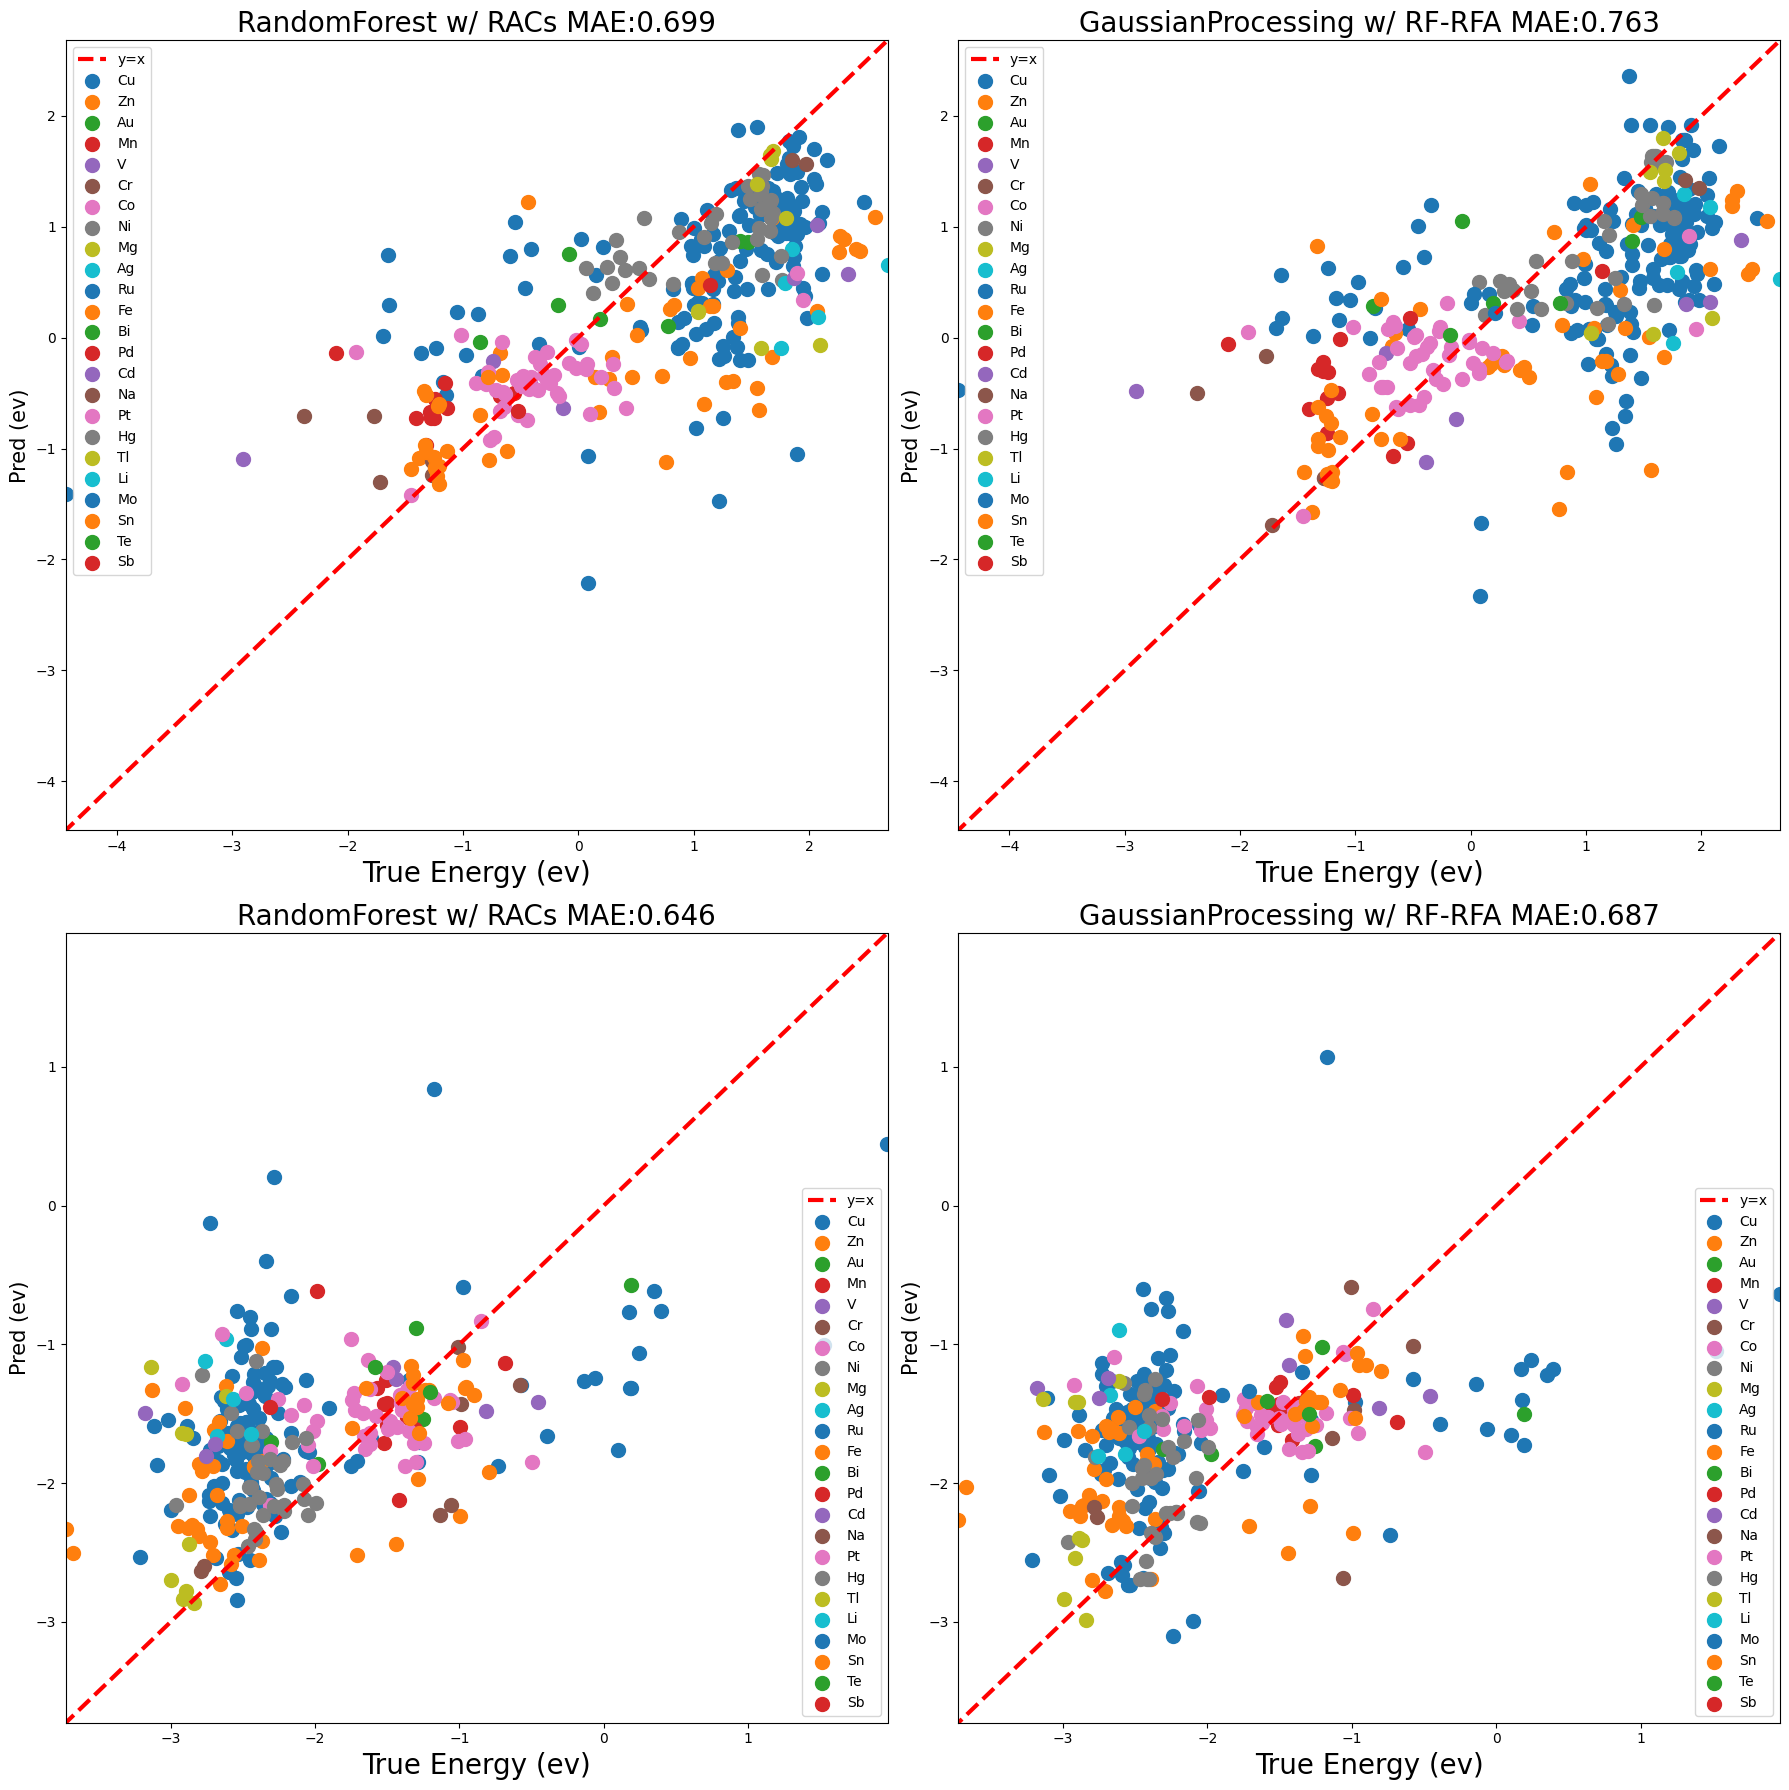

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
import colorlover as cl

# Create a figure with 4x4 subplots
props = ['oxo','h']
# columns = ["rf", "align-raw", "nn", "align-tl"]

n_rows = 2

n = 2

src_file_path = "/scratch/yll6162/MOF-oxo/labels/baremofdf_rem_inf_and_NN_q3.csv"
df_source = pd.read_csv(src_file_path, index_col = 0)
# df_source = df_source[df_source["Metal"] == "Cu"]
df_source['ids'] = df_source['MOF'] +'.cif_'+ df_source['Site'].astype(str)
df_source = df_source.drop_duplicates(subset = 'ids')

# Example data for each subplot
fig, axes = plt.subplots(len(props), n, figsize=(9 * n, 9 * len(props)))
for k, prop in enumerate(props):
    rf_racs = f"/scratch/yll6162/MOF-oxo/output/rf_pred_{prop}_1102_idx_cv.csv"
    gp_racs = f"/scratch/yll6162/MOF-oxo/output/gp_pred_{prop}_1102_idx_cv.csv"
    # nn_racs_only = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_pred_cv.csv"
    # nn_racs_dband = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_racs_dband_tl_pred_cv.csv"
    # nn_racs_form_e = f"/scratch/yll6162/CrossPropertyTL/pred/mof/query_1/mof_{prop}_form_e_pred_otf.csv"
    # nn_racs_bandgap = f"/scratch/yll6162/CrossPropertyTL/pred/mof/query_1/mof_{prop}_bandgap_pred_otf.csv"
    # nn_racs_form_e = f"/scratch/yll6162/CrossPropertyTL/pred/mof_{prop}_form_e_pred_cv.csv"
    # col_title = ["RandomForest w/ RACs", "GaussianProcessing w/ RF-RFA", "Formation Energy w/ Alignn Embeddings + RACs", "Bandgap w/ Alignn Embeddings + RACs",]
    col_title = ["RandomForest w/ RACs", "GaussianProcessing w/ RF-RFA"]

    file_paths = [rf_racs, gp_racs]
    for i, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, index_col = 0)
        df = df.merge(df_source, how='inner', left_on='ids_test', right_on = 'ids')
        preds = df["predictions"].values
        preds = np.clip(preds, None, 4)
        df['predictions'] = preds
        labels = df["labels"].values
        mae = np.mean(np.absolute(preds - labels))
        
        axes[k][i].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
        metals = df['Metal'].unique()
        axes[k][i].set_xlim(min(labels), max(labels))
        axes[k][i].set_ylim(min(labels), max(labels))
        axes[k][i].set_xlabel('True Energy (ev)', fontsize=20)
        axes[k][i].set_ylabel('Pred (ev)', fontsize=15)
        # axes[k][i].set_title(f"{file_path.split('/')[-1].rstrip('.csv')} MAE:{mae:.4f}", fontsize=20)
        axes[k][i].set_title(f"{col_title[i]} MAE:{mae:.3f}", fontsize=20)
        # axes[k][i].set_xticks(fontsize=13) 
        # axes[k][i].set_yticks(fontsize=13) 
        colormap = cl.to_numeric(cl.scales['12']['qual']['Set3'])
        # colors = [cl.to_numeric(c) for c in colormap]
        for j, metal in enumerate(metals):
            labels = df[df["Metal"] == metal]['labels'].values
            preds = df[df["Metal"] == metal]['predictions'].values
            axes[k][i].scatter(labels, preds, s=100, marker='o', label = metal)
        axes[k][i].legend()
# for i in range(n_rows):
#     for j in range(n_cols):
#         row = rows[i]
#         col = columns[j]
#         axes[i, j].set_title(f'{row}_{col}')
#         filename = "_".join([col.split("_")[0], row, col.split("_")[1], prop]) + '.csv'
#         df = pd.read_csv(os.path.join("pred", filename))
#         preds = df["predictions"].values
#         labels = df["labels"].values
#         axes[i, j].scatter(labels, preds)
#         axes[i, j].plot([-100, 100], [-100, 100], '--r', label='y=x', linewidth=3)
#         axes[i, j].set_xlim(min(labels), max(labels))
#         axes[i, j].set_ylim(min(labels), max(labels))

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [33]:
df_var.shape

(8113, 26)

In [22]:
import pandas as pd
df_init = pd.read_csv("/scratch/yll6162/MOF-oxo/labels/qmofruns_2.csv", index_col = 0)
df_latest = pd.read_csv("/scratch/yll6162/MOF-oxo/labels/baremof_rem_inf_out.csv", index_col = 0)
df_init['id_str'] = df_init.MOF + "_" + df_init.Site.astype(str)
df_latest['id_str'] = df_latest.MOF + "_" + df_latest.Site.astype(str)
df_init_clean = df_latest[df_latest.id_str.isin(df_init.id_str)]
df_init_clean.drop("Unnamed: 0", errors="ignore").to_csv("/scratch/yll6162/MOF-oxo/labels/qmofruns_2_cleaned.csv")

In [20]:
df_init

,index,MOF,E_MOF (eV),Site,Metal,Oxo Formation Energy,Hydrogen Affinity Energy,E_MOF_O (eV),E_MOF_OH (eV),id_str
0,37,qmof-0e1877f,-582.008500,0,Cu,1.500390,-2.491565,-585.248109,-591.129674,qmof-0e1877f_0
1,62,qmof-75d4f07,-577.895252,0,Cu,1.922828,-3.019133,-580.712423,-587.121557,qmof-75d4f07_1
2,81,qmof-0a3a813,-485.702175,0,Na,1.835291,-1.657621,-488.606884,-493.654505,qmof-0a3a813_2
3,82,qmof-0b0f0b1,-425.945243,0,K,2.496165,-2.544621,-428.189078,-434.123699,qmof-0b0f0b1_3
4,149,qmof-0e4f65c,-625.219444,0,Ag,-1.155837,0.051744,-631.115282,-634.453538,qmof-0e4f65c_4
...,...,...,...,...,...,...,...,...,...,...
434,18638,qmof-ed37e1c,-749.196446,0,Co,-1.276574,-0.287166,-755.213021,-758.890187,qmof-ed37e1c_434
435,18717,qmof-32a2afb,-386.468998,0,Co,0.303155,-2.047567,-390.905843,-396.343410,qmof-32a2afb_435
436,20173,qmof-22a3730,-936.289981,0,Mg,1.580740,-2.613767,-939.449241,-945.453009,qmof-22a3730_436
437,20372,qmof-0dce90f,-913.083401,0,Cu,0.977373,-2.325312,-916.846028,-922.561340,qmof-0dce90f_437


In [16]:
df_init["id_str"].values

array(['qmof-0e1877f_0', 'qmof-75d4f07_1', 'qmof-0a3a813_2',
       'qmof-0b0f0b1_3', 'qmof-0e4f65c_4', 'qmof-0b3d138_5',
       'qmof-89fb1f3_6', 'qmof-0a8808d_7', 'qmof-0a8808d_8',
       'qmof-0a8808d_9', 'qmof-002580c_10', 'qmof-0f25b5a_11',
       'qmof-0ac7a90_12', 'qmof-0ac7a90_13', 'qmof-1766203_14',
       'qmof-0bdd243_15', 'qmof-0bdd243_16', 'qmof-1b6c849_17',
       'qmof-5947f65_18', 'qmof-0cfad40_19', 'qmof-c7761f6_20',
       'qmof-90b97bc_21', 'qmof-0b98df9_22', 'qmof-6262763_23',
       'qmof-29248f6_24', 'qmof-2f8d683_25', 'qmof-ad7ce98_26',
       'qmof-1ee9184_27', 'qmof-1ee9184_28', 'qmof-5a2471d_29',
       'qmof-0de6ab6_30', 'qmof-13f00c5_31', 'qmof-e603f7e_32',
       'qmof-ad90d19_33', 'qmof-0f56a20_34', 'qmof-0f56a20_35',
       'qmof-6e31a87_36', 'qmof-6e31a87_37', 'qmof-a8abb47_38',
       'qmof-39b825c_39', 'qmof-41c3d42_40', 'qmof-75309dd_41',
       'qmof-0f0d142_42', 'qmof-0f0d142_43', 'qmof-09a1847_44',
       'qmof-ba9fbf5_45', 'qmof-5d291cb_46', 'qmof

In [19]:
df_latest["id_str"].values
#Plot selected top k predictions


array(['qmof-0c10f91_0', 'qmof-0c122db_1', 'qmof-0c12dcf_2',
       'qmof-0c3622c_3', 'qmof-0c56ddf_4', 'qmof-0c90bee_5',
       'qmof-0c9867d_6', 'qmof-0ca8b3d_7', 'qmof-0caf0c5_8',
       'qmof-0cd4232_9', 'qmof-0cecd6b_10', 'qmof-0cf115b_11',
       'qmof-0cfa193_12', 'qmof-0cfad40_13', 'qmof-0d1d4bd_14',
       'qmof-0d42aa5_15', 'qmof-0d451dd_16', 'qmof-0d4a2d9_17',
       'qmof-0d5ee20_18', 'qmof-0d5ee20_19', 'qmof-0d66641_20',
       'qmof-0d69406_21', 'qmof-0d837fe_22', 'qmof-0d83a18_23',
       'qmof-0d96be5_24', 'qmof-0db1e73_25', 'qmof-0dce90f_26',
       'qmof-0dce90f_27', 'qmof-0de6ab6_28', 'qmof-0df517f_29',
       'qmof-0df8088_30', 'qmof-0e116bf_31', 'qmof-0e1877f_32',
       'qmof-0e29314_33', 'qmof-0e4f65c_34', 'qmof-0e5bc0c_35',
       'qmof-0e5bf14_36', 'qmof-0e73e01_37', 'qmof-0e7dcd2_38',
       'qmof-0e7dcd2_39', 'qmof-0e91fcd_40', 'qmof-0e9a127_41',
       'qmof-0ec4fb0_42', 'qmof-0ec6421_43', 'qmof-0ed4bf6_44',
       'qmof-0ee131b_45', 'qmof-0f00c40_46', 'qmof

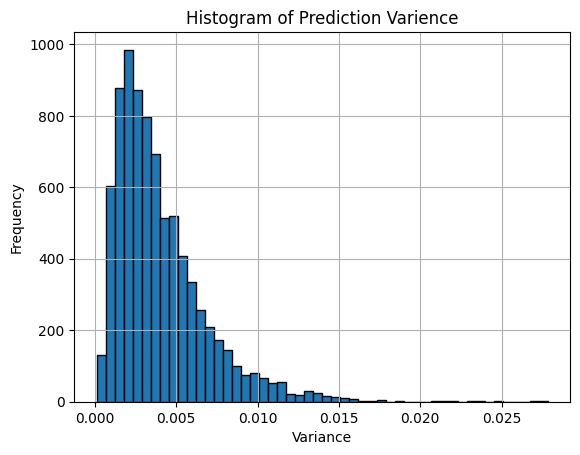

In [13]:
### Histogram of varience
# prop = "oxo"
# rf_file_path = f"/scratch/yll6162/MOF-oxo/output/rf_pred_{prop}_idx_iter_all_var.csv"
# df_var = pd.read_csv(rf_file_path, index_col = 0)
# plt.hist(df_var['row_variances'], bins=50, edgecolor='black')  # Adjust the number of bins as needed
# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Histogram of Prediction Varience')
# plt.grid(True)
# plt.show()

In [6]:
list_fea = ['racs_bb-linker_connecting_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum', 'racs_bb-linker_functional_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-linker_functional_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum', 'racs_bb-nodes_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum', 'Metal_Cd', 'Metal_Co', 'Metal_Ni']
len(list_fea)

12

In [7]:
fea_score = {'racs_bb-nodes_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': 0, 'racs_bb-nodes_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.05351240634367671, 'Metal_Co': 0.002526248482740079, 'racs_bb-nodes_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.03416930943837071, 'Metal_Mn': 0.003058841494363973, 'racs_bb-nodes_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.017966569490135975, 'racs_bb-nodes_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.02073959395845193, 'racs_bb-nodes_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.004213714249518219, 'racs_bb-nodes_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.018807386674834614, 'racs_bb-nodes_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0005942176417915723, 'racs_bb-nodes_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.003404507754890318, 'racs_bb-nodes_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.05188998320592697, 'racs_bb-nodes_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.03809128163967945, 'Metal_Fe': 0.0016801915837700854, 'racs_bb-linker_connecting_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.02622612478213604, 'racs_bb-nodes_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.021018454788509056, 'racs_bb-linker_connecting_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.022043682279828447, 'racs_bb-nodes_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0029086172827490486, 'racs_bb-nodes_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': 0.0019268078895892105, 'racs_bb-nodes_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.03623900839823979, 'racs_bb-linker_connecting_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.02711002961601716, 'racs_bb-linker_all_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.03703191015474239, 'racs_bb-nodes_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.035088840298716506, 'racs_bb-nodes_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.03363218618859998, 'racs_bb-linker_all_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.030417623443099062, 'racs_bb-nodes_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.0013445696257957662, 'racs_bb-linker_functional_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.009972069694587304, 'racs_bb-linker_connecting_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.020189731951343215, 'racs_bb-nodes_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.025148102938653327, 'racs_bb-nodes_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.019258682639770264, 'racs_bb-nodes_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.02734222704947431, 'racs_bb-linker_functional_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.008601679322727152, 'racs_bb-linker_functional_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.02422159206070207, 'racs_bb-nodes_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.012746395441869396, 'racs_bb-linker_connecting_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.010501224518415286, 'racs_bb-linker_all_prop-covalent_radius_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.02404523546764925, 'racs_bb-linker_all_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.018895468382607916, 'racs_bb-linker_functional_prop-z_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.00755500603820447, 'racs_bb-linker_all_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.03894816907910581, 'racs_bb-linker_connecting_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.01973420251998448, 'racs_bb-linker_connecting_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.015040817749919722, 'racs_bb-linker_functional_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.02035920985648354, 'racs_bb-linker_functional_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.011428857507981727, 'racs_bb-linker_functional_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.009372924175923725, 'racs_bb-linker_functional_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.004531122643986585, 'racs_bb-nodes_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.00544302374401906, 'racs_bb-linker_connecting_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.026749179572479465, 'racs_bb-linker_all_prop-X_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.02423418975501468, 'racs_bb-linker_functional_prop-X_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.026078458727038845, 'racs_bb-linker_connecting_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.016282060302712953, 'racs_bb-linker_all_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.024484249777428246, 'racs_bb-linker_all_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.021401781438748824, 'racs_bb-nodes_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.004662495800361044, 'racs_bb-linker_functional_prop-covalent_radius_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.013768676407582392, 'racs_bb-linker_functional_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.009002248520097234, 'racs_bb-linker_functional_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.002427272792860813, 'racs_bb-nodes_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01876944973351502, 'racs_bb-linker_connecting_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.025255575829321253, 'racs_bb-nodes_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.023325620338715325, 'racs_bb-linker_all_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.039509815407144266, 'racs_bb-linker_connecting_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.02430267674247233, 'racs_bb-linker_connecting_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.027071783235621094, 'racs_bb-linker_all_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.02290161169687477, 'racs_bb-linker_connecting_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.025296292303765733, 'racs_bb-linker_functional_prop-z_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.010479996794058533, 'racs_bb-linker_functional_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.010792256540875567, 'racs_bb-nodes_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.008292237368272226, 'racs_bb-linker_functional_prop-z_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.0213492911376717, 'racs_bb-linker_all_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.010763991329547418, 'racs_bb-linker_all_prop-X_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.032475443361152934, 'racs_bb-linker_all_prop-T_scope-3_propagg-diff_corragg-sum_bbagg-sum': -0.01433414205745831, 'racs_bb-linker_all_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.025543639152211917, 'racs_bb-linker_functional_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.0038032472840104914, 'racs_bb-linker_all_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.034827375372114, 'racs_bb-linker_all_prop-z_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01832327620433427, 'racs_bb-linker_functional_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.0181841398145951, 'racs_bb-linker_connecting_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.02473574770568021, 'racs_bb-linker_all_prop-T_scope-2_propagg-diff_corragg-sum_bbagg-sum': -0.020870687793846487, 'racs_bb-linker_functional_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.015523305167039703, 'racs_bb-linker_connecting_prop-T_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.028766753706221615, 'racs_bb-linker_all_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.05076663674202997, 'racs_bb-linker_connecting_prop-z_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.029545506149501466, 'racs_bb-linker_functional_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01058255380178652, 'racs_bb-linker_connecting_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.016440343667266433, 'racs_bb-linker_connecting_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.02084482522230402, 'racs_bb-linker_functional_prop-T_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.01429651997509096, 'racs_bb-linker_functional_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.031834948321173395, 'racs_bb-linker_connecting_prop-covalent_radius_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.01846870156655389, 'racs_bb-linker_all_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.026460345417888664, 'racs_bb-linker_connecting_prop-X_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.00582157118089488, 'racs_bb-linker_all_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.039877539005529594, 'racs_bb-linker_all_prop-T_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.01575231989892567, 'racs_bb-linker_all_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.026244842357201814, 'racs_bb-linker_all_prop-covalent_radius_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.02297676075255639, 'racs_bb-linker_all_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.03160882414612276, 'racs_bb-linker_connecting_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.024232052630950962, 'racs_bb-linker_functional_prop-z_scope-1_propagg-diff_corragg-sum_bbagg-sum': -0.01355405340950433, 'racs_bb-linker_connecting_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.024456974482266802, 'racs_bb-linker_connecting_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.013593596415952258, 'racs_bb-linker_all_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.031034943750495092, 'racs_bb-linker_functional_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.005390940772581176, 'racs_bb-linker_connecting_prop-X_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.00994666806765565, 'racs_bb-linker_functional_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.009133768483985727, 'racs_bb-linker_functional_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.017143025960005165, 'racs_bb-linker_connecting_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': -0.009374554137624447, 'racs_bb-nodes_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.019597402206508963, 'racs_bb-linker_all_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.028179384318875123, 'racs_bb-linker_all_prop-X_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.022753055005290346, 'racs_bb-linker_functional_prop-covalent_radius_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.013220343968441628, 'racs_bb-linker_functional_prop-z_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.00905241660195566, 'racs_bb-linker_all_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.03614613436337322, 'racs_bb-linker_connecting_prop-covalent_radius_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.02778124092579215, 'racs_bb-linker_connecting_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.021499664213163627, 'racs_bb-linker_functional_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.011349441619601941, 'racs_bb-linker_all_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.02869163653359985, 'racs_bb-linker_connecting_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.017941453918340566, 'racs_bb-linker_connecting_prop-T_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.023177949212693782, 'racs_bb-linker_all_prop-covalent_radius_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.03000271350056749, 'racs_bb-nodes_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.007113728964794008, 'racs_bb-linker_connecting_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.023950740944748028, 'racs_bb-linker_functional_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.000682203471298326, 'racs_bb-linker_all_prop-X_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.0367791796329906, 'racs_bb-linker_functional_prop-I_scope-2_propagg-product_corragg-sum_bbagg-sum': -0.024369765330327198, 'Metal_Cu': 4.564911954463291e-05, 'racs_bb-linker_functional_prop-I_scope-3_propagg-product_corragg-sum_bbagg-sum': -0.006216117786432607, 'racs_bb-linker_connecting_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': -0.017154914843583224, 'Metal_Ag': 0.0029815782469488905, 'racs_bb-nodes_prop-I_scope-1_propagg-product_corragg-sum_bbagg-sum': 0.0029469830237207617, 'Metal_Na': 0.00031870769404662713, 'Metal_K': 0.0025361009806643686, 'Metal_Li': 2.2848718115753286e-05, 'Metal_Pd': 0.0014440197042717706, 'Metal_Cd': 0.0017046531656186303, 'Metal_Sb': 0.0021508304946497026, 'Metal_Zn': 0.00035014543944678067, 'Metal_Ni': 0.001899750978009207, 'Metal_Cr': 0.0014810281031030215, 'Metal_Ga': 0.002713264274799676, 'Metal_Pt': 0.001379198013737315, 'Metal_Hg': 0.0029296009151937863, 'Metal_In': 0.0020812839217123624, 'Metal_Mo': 0.001320044384992114, 'Metal_Au': 0.0018021769075919902, 'Metal_Ca': 4.160870024272345e-05, 'Metal_Sn': 0.00019851744745991162, 'Metal_N': 0.000184916011947589, 'Metal_Mg': -0.00018820161988453155, 'Metal_Bi': 0.000648322443990712, 'Metal_V': 0.000216701013663112, 'Metal_Tl': 0.00126685388777259, 'Metal_Te': -0.0004451015808613068, 'Metal_As': -0.00010407494454800492, 'Metal_Pb': 0.0016303208930738, 'racs_bb-linker_all_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_O': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010604739, 'racs_bb-nodes_prop-I_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Rb': 0.0002908464010606959, 'Metal_Rh': 0.0002908464010606959, 'Metal_Ru': 0.0002908464010606959, 'Metal_Sm': 0.0002908464010606959, 'Metal_Sr': 0.0002908464010606959, 'Metal_Tb': 0.0002908464010606959, 'Metal_U': 0.0002908464010606959, 'Metal_Yb': 0.00029084640106091797, 'racs_bb-linker_all_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_functional_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.00029084640106091797, 'racs_bb-linker_functional_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_connecting_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.00029084640106091797, 'racs_bb-linker_all_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-nodes_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Al': 0.0002908464010606959, 'Metal_Ba': 0.0002908464010606959, 'Metal_C': 0.0002908464010606959, 'racs_bb-nodes_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.00029084640106091797, 'Metal_Cl': 0.0002908464010606959, 'racs_bb-nodes_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Cs': 0.0002908464010606959, 'racs_bb-linker_functional_prop-I_scope-3_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'Metal_Dy': 0.0002908464010606959, 'Metal_Er': 0.0002908464010606959, 'Metal_F': 0.0002908464010606959, 'racs_bb-linker_functional_prop-I_scope-2_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-nodes_prop-T_scope-0_propagg-product_corragg-sum_bbagg-sum': 0.0002908464010606959, 'racs_bb-linker_all_prop-I_scope-1_propagg-diff_corragg-sum_bbagg-sum': 0.0002908464010606959}

In [11]:
sorted_data = {k: v for k, v in sorted(fea_score.items(), key=lambda item: item[1], reverse=True)}

# Create a DataFrame from the sorted dictionary
df = pd.DataFrame(list(sorted_data.items()), columns=['Feature', 'MAE reduction'])

TypeError: Invalid shape (10000,) for image data

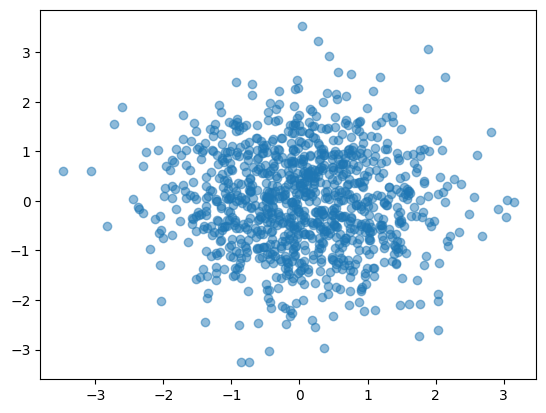

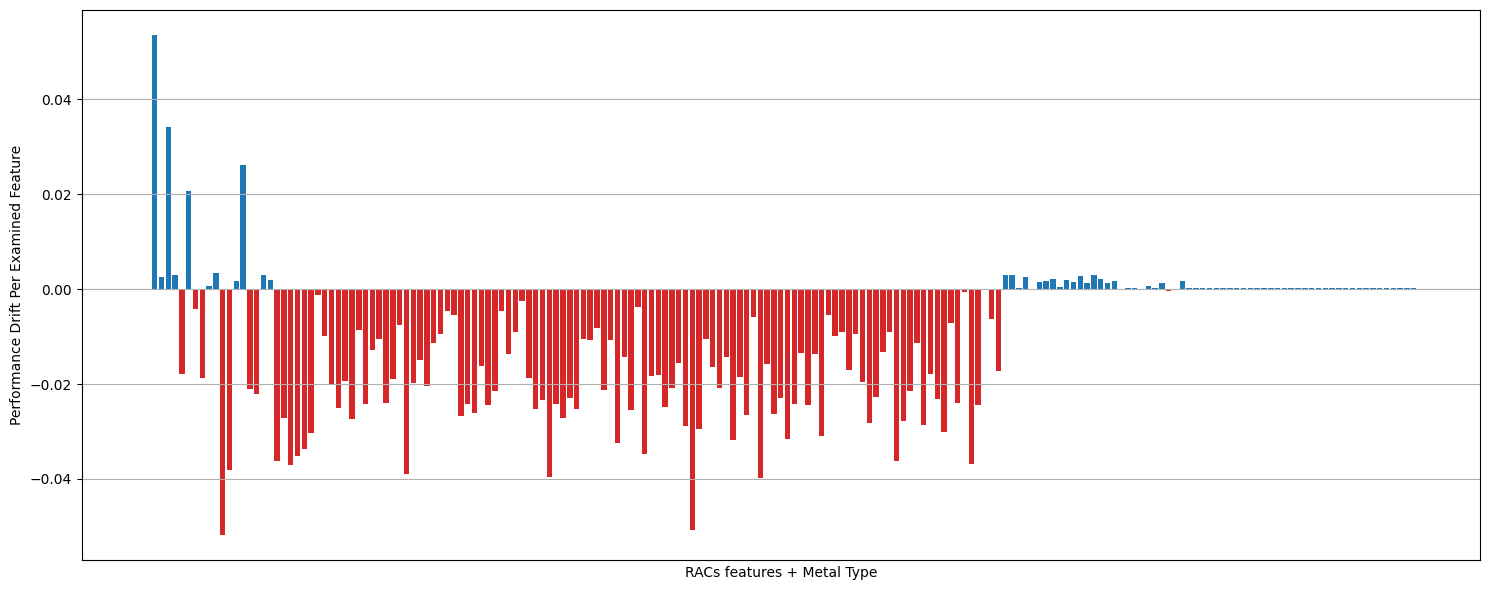

In [24]:
import matplotlib.pyplot as plt



# Extract keys and values for plotting
keys = fea_score.keys()
values = fea_score.values()
colors = ['tab:red' if value < 0 else 'tab:blue' for value in values]
plt.figure(figsize=(15, 6))
# Create a bar chart
plt.bar(keys, values, color = colors)

# Add labels and title (optional)
plt.xlabel('RACs features + Metal Type')
plt.ylabel('Performance Drift Per Examined Feature')

plt.xticks([])
plt.grid(True)
# Show the plot
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
df_label = pd.read_csv("/scratch/yll6162/MOF-oxo/labels/Combined_Energies_Removed_Infeasible_Out.csv", index_col = 0)
df_old_label = pd.read_csv("/scratch/yll6162/MOF-oxo/labels/qmofruns_2.csv", index_col = 0)


In [3]:
df_label

,index,MOF,E_MOF (eV),Band Gap (eV),Unnamed: 0,Oxo Formation Energy,Hydrogen Affinity Energy,Site,Metal,E_MOF_O (eV),E_MOF_OH (eV)
0,37,qmof-0e1877f,-582.008500,0.580857,38,1.500390,-2.491565,0,Cu,-585.248109,-591.129674
1,62,qmof-75d4f07,-577.895252,0.772402,61,1.922828,-3.019133,0,Cu,-580.712423,-587.121557
2,81,qmof-0a3a813,-485.702175,3.105916,20,1.835291,-1.657621,0,Na,-488.606884,-493.654505
3,82,qmof-0b0f0b1,-425.945243,3.135860,42,2.496165,-2.544621,0,K,-428.189078,-434.123699
4,149,qmof-0e4f65c,-625.219444,1.782580,40,-1.155837,0.051744,0,Ag,-631.115282,-634.453538
...,...,...,...,...,...,...,...,...,...,...,...
494,20173,qmof-22a3730,-936.289981,1.961688,11,1.580740,-2.613767,0,Mg,-939.449241,-945.453009
495,20343,qmof-80942aa,-858.236582,2.868996,83,1.232414,-2.473603,0,Cu,-861.744168,-867.607771
496,20343,qmof-80942aa,-858.236582,2.868996,84,1.060409,-2.329082,1,Cu,-861.916173,-867.635255
497,20372,qmof-0dce90f,-913.083401,3.383629,30,0.977373,-2.325312,0,Cu,-916.846028,-922.561340


In [4]:
df_old_label

,index,MOF,E_MOF (eV),Site,Metal,Oxo Formation Energy,Hydrogen Affinity Energy,E_MOF_O (eV),E_MOF_OH (eV)
0,37,qmof-0e1877f,-582.008500,0,Cu,1.500390,-2.491565,-585.248109,-591.129674
1,81,qmof-0a3a813,-485.702175,0,Na,1.835291,-1.657621,-488.606884,-493.654505
2,82,qmof-0b0f0b1,-425.945243,0,K,2.496165,-2.544621,-428.189078,-434.123699
3,149,qmof-0e4f65c,-625.219444,0,Ag,-1.155837,0.051744,-631.115282,-634.453538
4,186,qmof-0b3d138,-797.538468,0,Cu,-2.277110,1.529833,-804.555577,-806.415745
...,...,...,...,...,...,...,...,...,...
315,18605,qmof-3dfbcbd,-151.892256,5,Pt,1.893191,-2.474841,-154.739065,-160.603907
316,18638,qmof-ed37e1c,-749.196446,0,Co,-1.276574,-0.287166,-755.213021,-758.890187
317,18717,qmof-32a2afb,-386.468998,0,Co,0.303155,-2.047567,-390.905843,-396.343410
318,20372,qmof-0dce90f,-913.083401,0,Cu,0.977373,-2.325312,-916.846028,-922.561340


In [9]:
result = df_label.merge(df_old_label[['MOF', 'index']], on=['MOF', 'index'], how='left', indicator=True)
left_anti_join_result = result[result['_merge'] == 'left_only'].drop(columns='_merge')
left_anti_join_result.to_csv("/scratch/yll6162/MOF-oxo/labels/Combined_Energies_Removed_Infeasible_Out_new_only.csv")


In [7]:
# h2o 
import h2o
from h2o.automl import H2OAutoML

h2o.init()
classifier_model = h2o.load_model("/scratch/yll6162/MOF-oxo/classification/StackedEnsemble_BestOfFamily_8_AutoML_1_20240601_203645")
# Convert X_test to H2OFrame
# Get the cross-validation metrics for the best model
# Get the metalearner
# metalearner = classifier_model.metalearner_model()
# print("Metalearner model details:")
# print(metalearner)

# Get the base models
base_models = classifier_model.base_models
print("Base models in the stacked ensemble:")
for model_id in base_models:
    model = h2o.get_model(model_id)
    print(f"Model ID: {model_id}, Model Type: {model.algo}, AUC: {model.auc()}")


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 38 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_yll6162_nln878
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,25.22 Gb
H2O_cluster_total_cores:,48
H2O_cluster_allowed_cores:,48
H2O_cluster_status:,"locked, healthy"


Base models in the stacked ensemble:
Model ID: XGBoost_grid_1_AutoML_1_20240601_203645_model_42, Model Type: xgboost, AUC: 0.9546874645233067
Model ID: GBM_grid_1_AutoML_1_20240601_203645_model_56, Model Type: gbm, AUC: 0.9559975478509638
Model ID: XRT_1_AutoML_1_20240601_203645, Model Type: drf, AUC: 0.7656540199350635
Model ID: DRF_1_AutoML_1_20240601_203645, Model Type: drf, AUC: 0.7650795813182572
Model ID: DeepLearning_grid_2_AutoML_1_20240601_203645_model_1, Model Type: deeplearning, AUC: 0.9345662193765184
Model ID: GLM_1_AutoML_1_20240601_203645, Model Type: glm, AUC: 0.7487591671775311


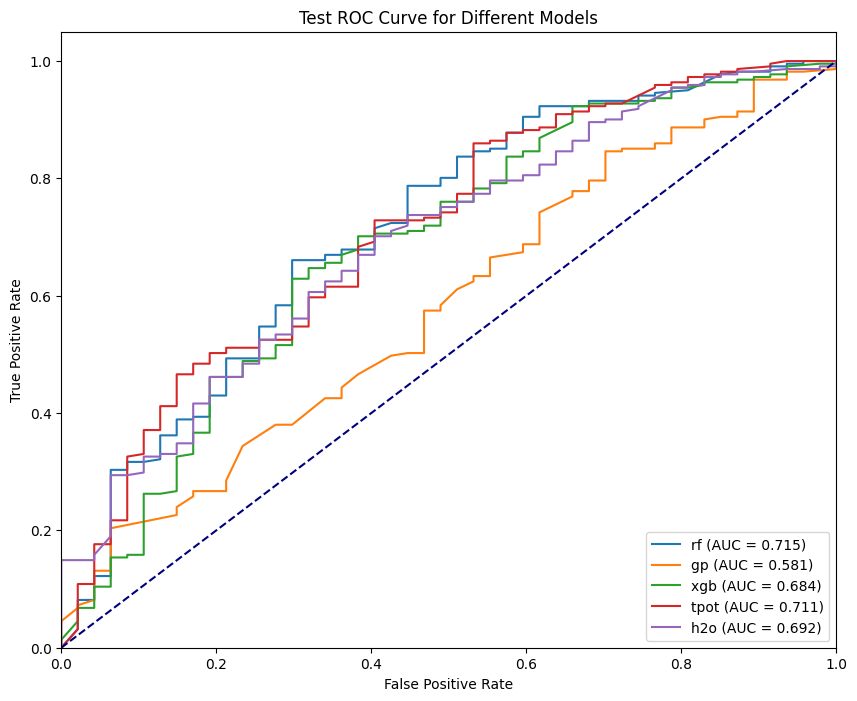

In [3]:
# classifier cv plots

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import glob

# Function to plot ROC curve for each file
def plot_roc_curves(file_list):
    plt.figure(figsize=(10,8))
    for file in file_list:
        df = pd.read_csv(file)
        fpr, tpr, _ = roc_curve(df['y_test'], df['y_prob'])
        roc_auc = auc(fpr, tpr)
        algo = file.split('/')[-1].split('_')[0]
        plt.plot(fpr, tpr, label=f'{algo} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC Curve for Different Models')
    plt.legend(loc='lower right')
    plt.show()

# List of CSV files
# file_list = glob.glob('path/to/csv/files/*.csv')
file_list = ["/scratch/yll6162/MOF-oxo/classification/rf_dataset_0_dataset_12_pred_cls_test_prob.csv", 
             "/scratch/yll6162/MOF-oxo/classification/gp_dataset_0_dataset_12_pred_cls_test_prob.csv",
             "/scratch/yll6162/MOF-oxo/classification/xgb_dataset_0_dataset_12_pred_cls_test_prob.csv",
             "/scratch/yll6162/MOF-oxo/classification/tpot_dataset_0_dataset_12_pred_cls_test_prob.csv", 
             "/scratch/yll6162/MOF-oxo/classification/h2o_dataset_0_dataset_12_pred_cls_test_prob.csv"]

# Plot ROC curves
plot_roc_curves(file_list)
